# Evaluate Gradient Masking

This notebook runs some checks to determine if the networks may be gradient masked.
These checks may take some time and are not necessarily suitable as metrics themselves.

In [1]:
import argparse
import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, FGSM
from advertorch.attacks import LinfSPSAAttack
from src.trainers import Trainer, FGSMTrainer
from robustbench.model_zoo.models import Carmon2019UnlabeledNet
from src.utils import adversarial_accuracy, fgsm_
import eagerpy as ep
from src.Nets import CIFAR_Wide_Res_Net, CIFAR_Res_Net, CIFAR_Net, ResNet18GradReg
from src.gradient_masking_tests import run_masking_benchmarks
%load_ext autoreload
%autoreload 2
%aimport src.Nets, src.trainers

## Setup to import trained CIFAR-10 Models

In [2]:
# setup
device = torch.device("cuda")
batch_size = 32
# remove the normalize
transform = transform = transforms.Compose(
            [transforms.ToTensor()]
)
        
normalized_min = (0 - 0.5) / 0.5
normalized_max = (1 - 0.5) / 0.5
train_dataset = datasets.CIFAR10(root='../data', train=True,
                                download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=2)
test_dataset = datasets.CIFAR10(root='../data', train=False,
                               download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)
classes = classes = ('plane', 'car', 'bird', 'cat',
   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Load Trained Models

In [12]:
# # Regular CIFAR-10  ResNet Model
model = CIFAR_Res_Net(device).eval()
model.load_state_dict(torch.load("../models/cifar_res_net.model"))
# CIFAR-10  ResNet Model trained with large FGSM steps
fgsm_model = CIFAR_Res_Net(device).eval()
fgsm_model.load_state_dict(torch.load("../models/cifar_res_net_fgsm06.model"))
# # # CIFAR-10  ResNet Model trained with small FGSM steps
fgsm_model_small = CIFAR_Res_Net(device).eval()
fgsm_model_small.load_state_dict(torch.load("../models/cifar_res_net_20e_fgsm03.model"))
# # # CIFAR-10  ResNet Model trained with large Step-ll steps
step_ll_model = CIFAR_Res_Net(device).eval()
step_ll_model.load_state_dict(torch.load("../models/cifar_res_net_20e_stepll.model"))
# # CIFAR-10  ResNet Model trained through input gradient regularization ld2
gradient_norm_model = CIFAR_Res_Net(device).eval()
gradient_norm_model.load_state_dict(torch.load("../models/cifar_res_net_grad_reg_20e_ld2.model"))
# CIFAR-10  ResNet Model trained through input gradient regularization ld5
gradient_norm_model_strong = CIFAR_Res_Net(device).eval()
gradient_norm_model_strong.load_state_dict(torch.load("../models/cifar_res_net_grad_reg_20e_ld10.model"))
# # CIFAR-10  ResNet Model trained through Jacobian regularization ld0.1
jac_norm_model = CIFAR_Res_Net(device).eval()
jac_norm_model.load_state_dict(torch.load("../models/cifar_res_net_jac_reg_20e_ld_01.model"))
# CIFAR-10  ResNet Model trained through Jacobian regularization ld1
jac_norm_model_1 = CIFAR_Res_Net(device).eval()
jac_norm_model_1.load_state_dict(torch.load("../models/cifar_res_net_jac_reg_20e_ld_1.model"))
# CIFAR-10  ResNet Model trained through Jacobian regularization ld5
jac_norm_model_5 = CIFAR_Res_Net(device).eval()
jac_norm_model_5.load_state_dict(torch.load("../models/cifar_res_net_jac_reg_20e_ld_5.model"))
# CIFAR-10  ResNet Model trained through Jacobian regularization ld5
jac_norm_model_100 = CIFAR_Res_Net(device).eval()
jac_norm_model_100.load_state_dict(torch.load("../models/cifar_res_net_jac_reg_20e_ld_100.model"))

<All keys matched successfully>

# Run Benchmarks
### The benchmarks consist of:
- Standard Accuracy
- FGSM attack at different epsilons
- PGD attack
- Unbounded PGD attack
- Black Box (SPSA) Attack

For a gradient masked model, we might expect that:
- FGSM accuracy does not drop as epsilon increases
- PGD preforms worse than FGSM (turns out to not ever be the case)
- Unbounded PGD attack does not reach 0% accuracy
- Black box accuracy is lower than white box accuracy 

Notice that random attacks are stronger as epsilon increases

### Test Dataset

Model accuracy: 84.16%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 20.0%
SPSA accuracy - eps = 0.03: 17.0%



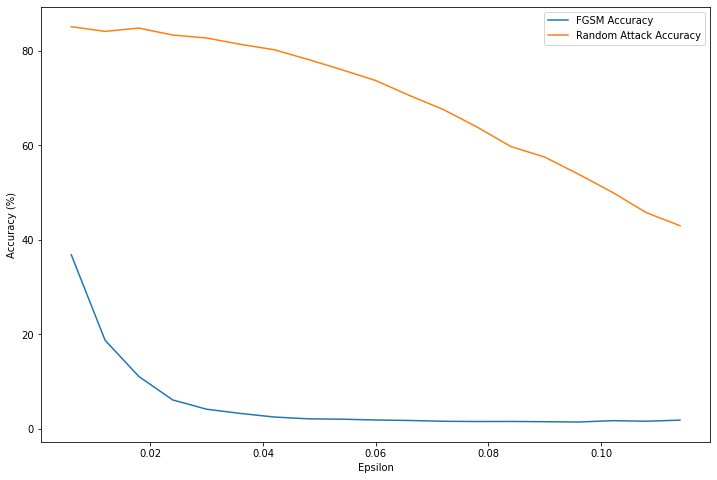

In [10]:
# Regular Model
run_masking_benchmarks(model, test_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Strangely, the fgsm model with large steps produces a model where increasing epsilon not only does not make the attack stronger, but instead, makes it much weaker.

In contrast, the model is significantly less robust at small epsilons.

It might be the case that we have created a subspace, beyond the decision boundary, making the model appear robust there.

However, this still does not explain how the model is now much more susceptible at smaller epsilons!

This seems to indicate the gradient is still informative?

#### The fgsm attack on eps=0.06 is WORSE than no attack at all!

Random attacks do not really get stronger as epsilon increases

Model accuracy: 72.34%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 3.0%
SPSA accuracy - eps = 0.03: 4.0%



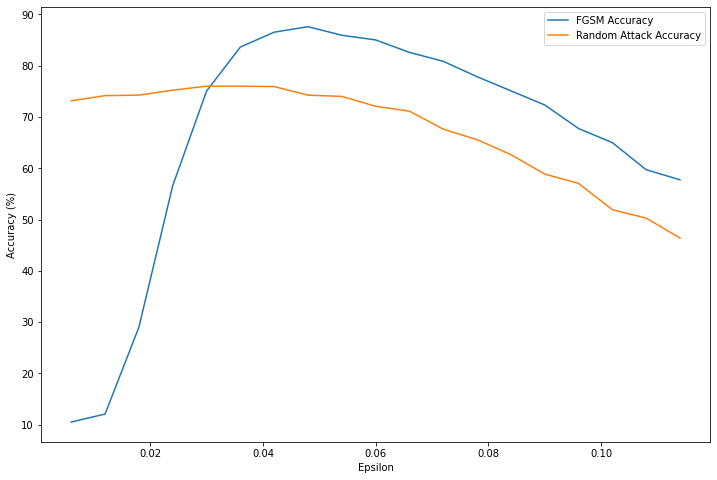

In [11]:
# fgsm model with large steps
run_masking_benchmarks(fgsm_model, test_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 69.19%
PGD accuracy - eps = 0.06: 9.120000000000001%
PGD accuracy - eps = 0.03: 9.120000000000001%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 39.0%
SPSA accuracy - eps = 0.03: 52.0%



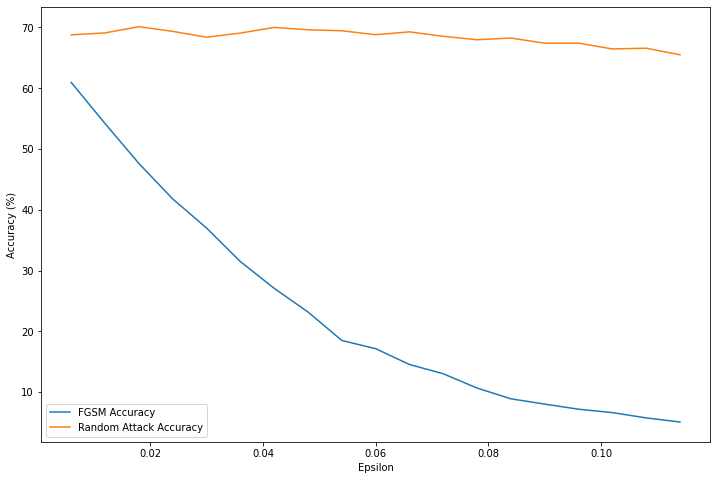

In [12]:
# fgsm model with small steps
run_masking_benchmarks(fgsm_model_small, test_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

### Step-ll potential gradient masking!
We notice that increasing epsilon does not improve the attack. 

However, unlike with FGSM, the model is more robust at small epsilons.

This together with black box outpreforming white box attacks, suggests an incidence of gradient masking

Random attacks do not really get stronger (actually get a bit weaker) as epsilon increases

Model accuracy: 72.72999999999999%
PGD accuracy - eps = 0.06: 1.5699999999999998%
PGD accuracy - eps = 0.03: 1.5699999999999998%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 16.0%
SPSA accuracy - eps = 0.03: 22.0%



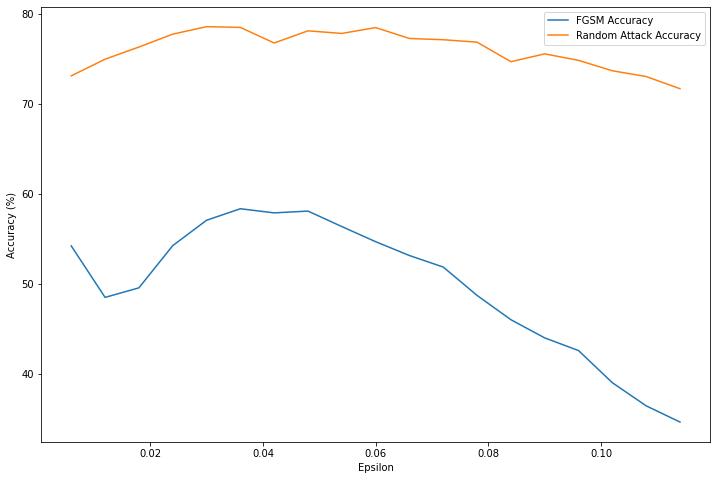

In [13]:
# step-ll model
run_masking_benchmarks(step_ll_model, test_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Gradient normalization model does become more robust.

Tried with 200 epochs, as in paper. all other nets 20e.

Not able to replicate reported accuracy at eps=0.03 (reported is ~42%)

Once more, random attacks get stronger as epsilon increases

Model accuracy: 84.83000000000001%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 15.0%
SPSA accuracy - eps = 0.03: 21.0%



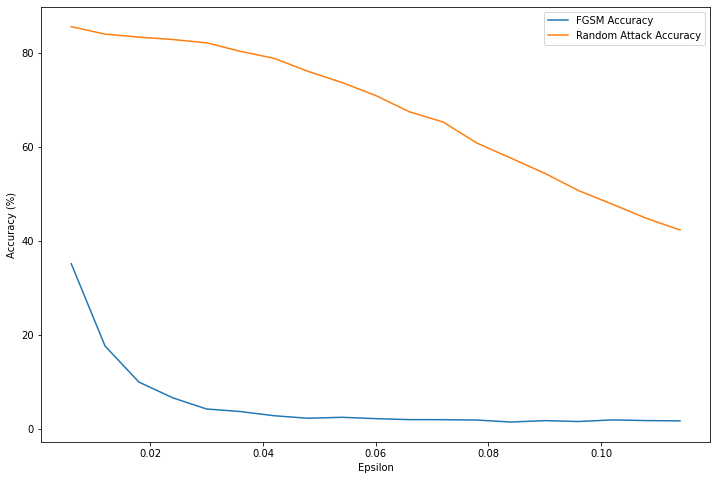

In [14]:
run_masking_benchmarks(gradient_norm_model, test_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 84.42%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 11.0%
SPSA accuracy - eps = 0.03: 21.0%



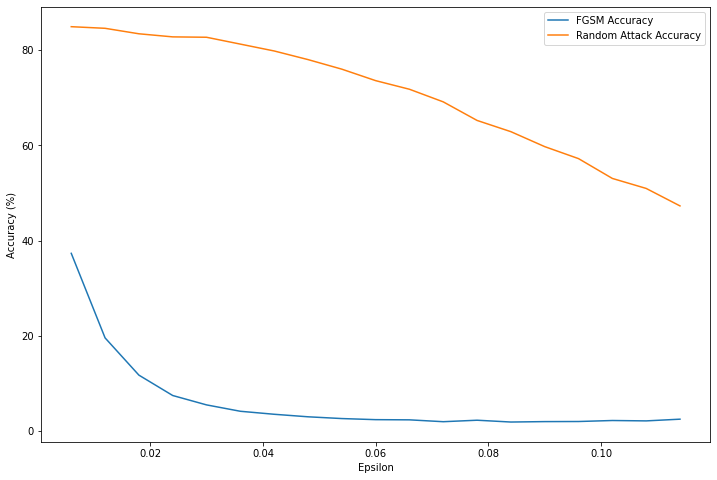

In [15]:
run_masking_benchmarks(gradient_norm_model_strong, test_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 83.95%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 14.000000000000002%
SPSA accuracy - eps = 0.03: 18.0%



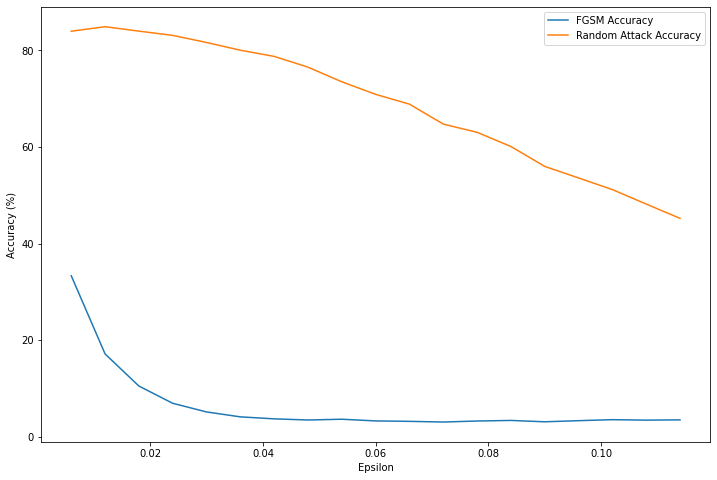

In [6]:
run_masking_benchmarks(jac_norm_model, test_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 84.67%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 17.0%
SPSA accuracy - eps = 0.03: 16.0%



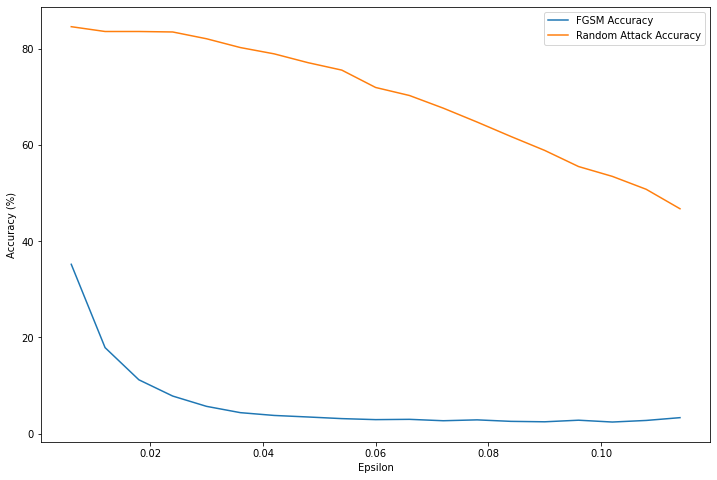

In [7]:
run_masking_benchmarks(jac_norm_model_1, test_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 85.11%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 23.0%
SPSA accuracy - eps = 0.03: 12.0%



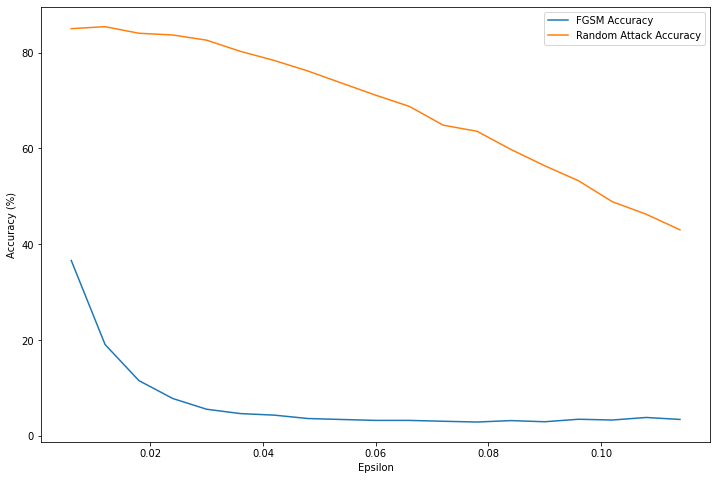

In [8]:
run_masking_benchmarks(jac_norm_model_5, test_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 85.08%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 21.0%
SPSA accuracy - eps = 0.03: 19.0%



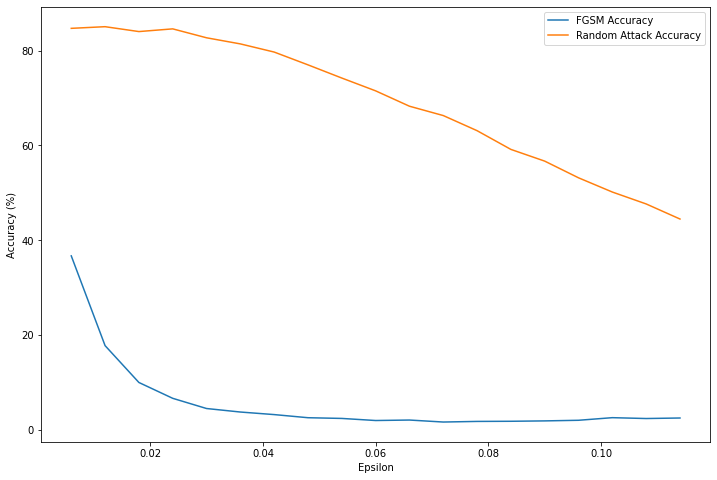

In [13]:
run_masking_benchmarks(jac_norm_model_100, test_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

## Wide RESNET Model

In [ ]:
run_masking_benchmarks(wide_model, test_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

In [ ]:
run_masking_benchmarks(wide_fgsm_model, test_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

### Train Dataset

Model accuracy: 100.0%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 14.000000000000002%
SPSA accuracy - eps = 0.03: 10.0%



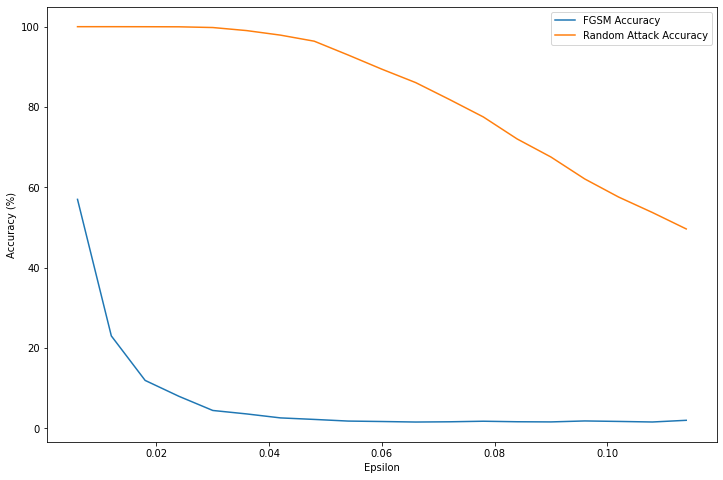

In [16]:
# Regular Model
run_masking_benchmarks(model, train_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 83.85000000000001%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 4.0%
SPSA accuracy - eps = 0.03: 11.0%



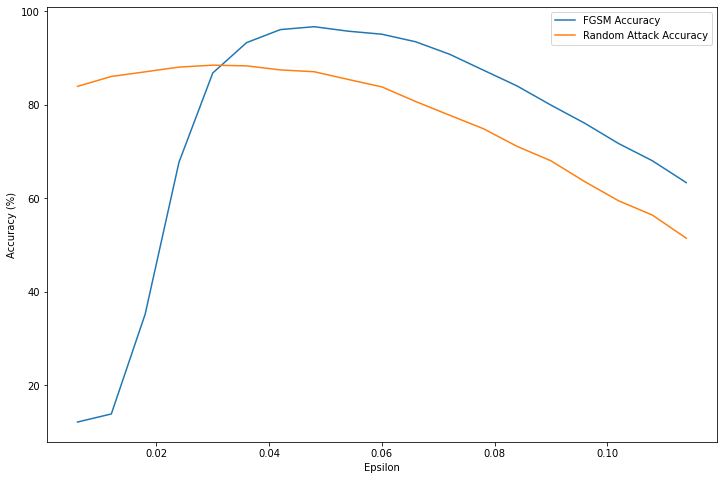

In [17]:
# fgsm model with large steps
run_masking_benchmarks(fgsm_model, train_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)


Model accuracy: 96.91%
PGD accuracy - eps = 0.06: 23.89%
PGD accuracy - eps = 0.03: 23.89%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 81.0%
SPSA accuracy - eps = 0.03: 95.0%



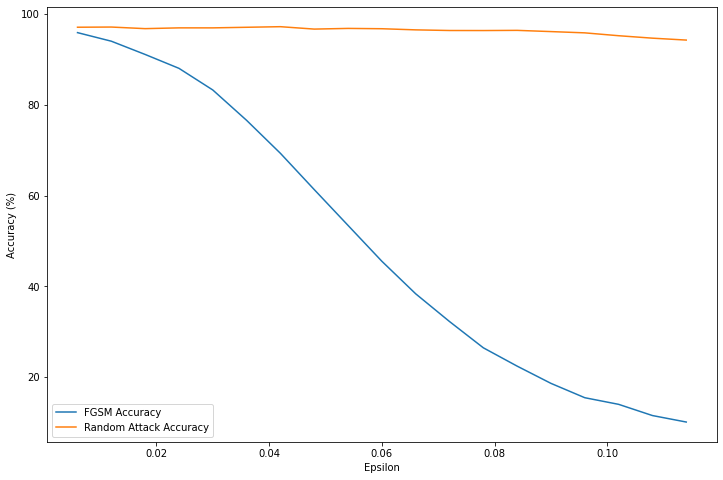

In [18]:
# fgsm model with small steps
run_masking_benchmarks(fgsm_model_small, train_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 97.46000000000001%
PGD accuracy - eps = 0.06: 2.5%
PGD accuracy - eps = 0.03: 2.5%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 40.0%
SPSA accuracy - eps = 0.03: 61.0%



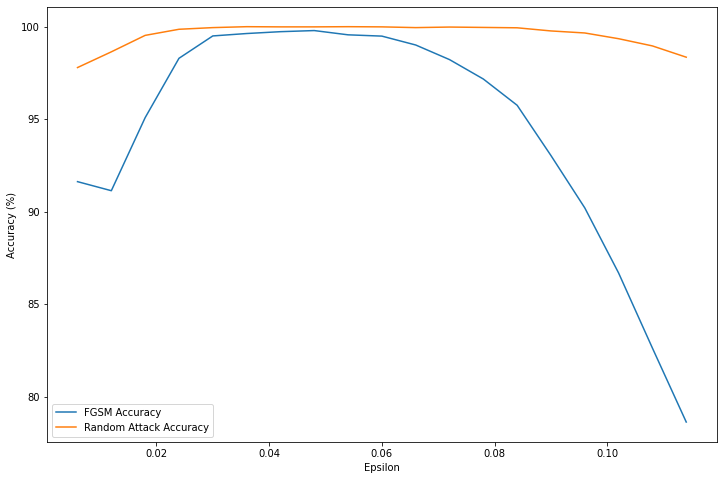

In [19]:
# step-ll model
run_masking_benchmarks(step_ll_model, train_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 100.0%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 19.0%
SPSA accuracy - eps = 0.03: 22.0%



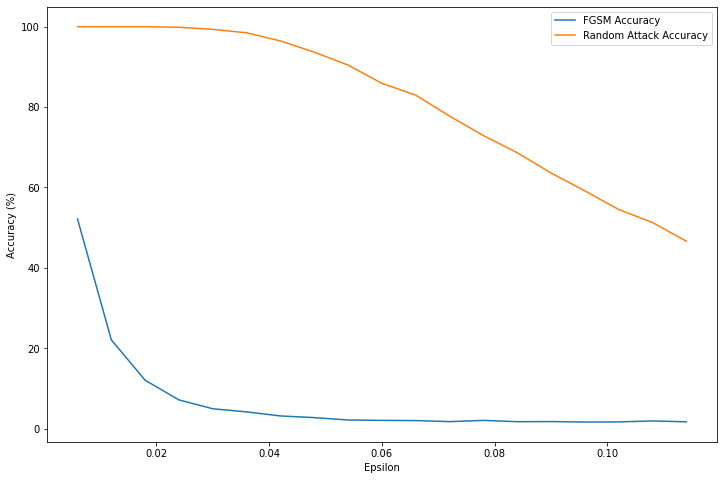

In [20]:
run_masking_benchmarks(gradient_norm_model, train_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 100.0%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 18.0%
SPSA accuracy - eps = 0.03: 16.0%



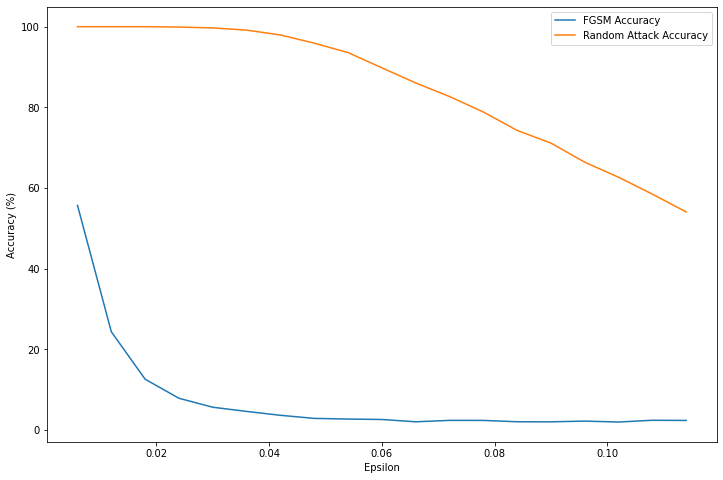

In [21]:
run_masking_benchmarks(gradient_norm_model_strong, train_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 100.0%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 23.0%
SPSA accuracy - eps = 0.03: 21.0%



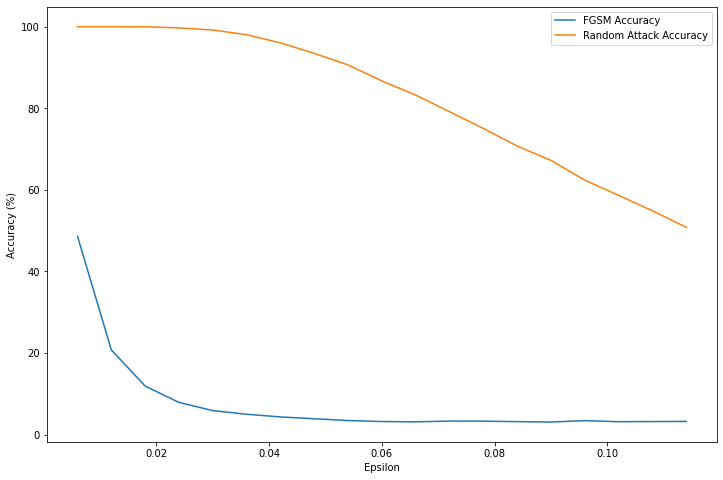

In [9]:
run_masking_benchmarks(jac_norm_model, train_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 100.0%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 21.0%
SPSA accuracy - eps = 0.03: 17.0%



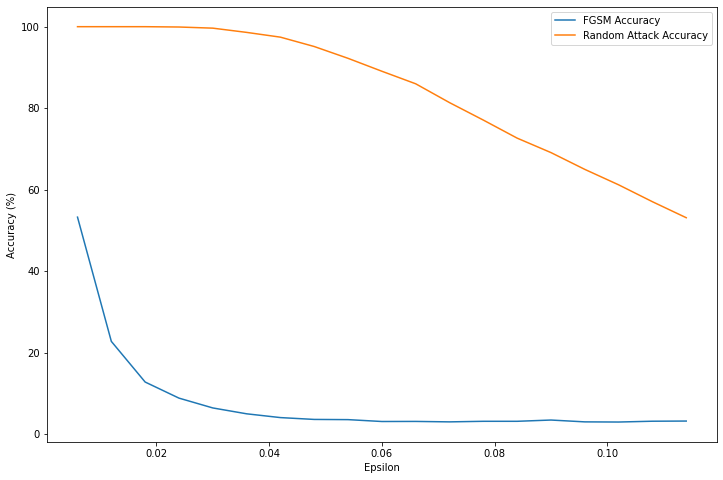

In [10]:
run_masking_benchmarks(jac_norm_model_1, train_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

Model accuracy: 100.0%
PGD accuracy - eps = 0.06: 0.0%
PGD accuracy - eps = 0.03: 0.0%
Unbounded PGD model accuracy: 0.0%
SPSA accuracy - eps = 0.06: 23.0%
SPSA accuracy - eps = 0.03: 20.0%



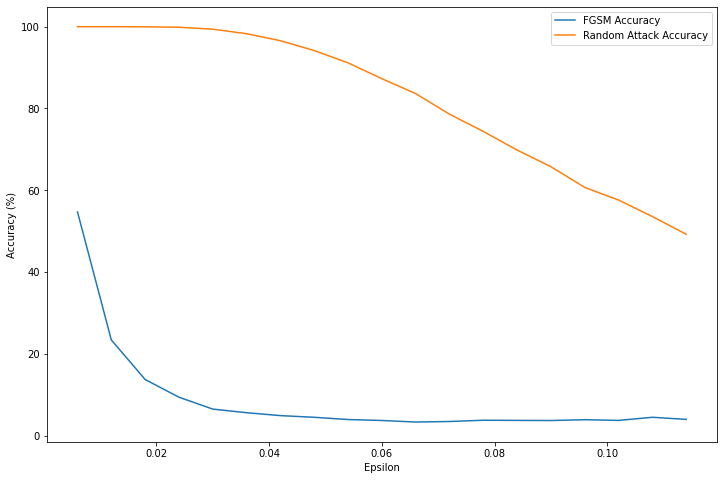

In [11]:
run_masking_benchmarks(jac_norm_model_5, train_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

In [14]:
run_masking_benchmarks(jac_norm_model_100, train_dataset, epsilon=0.06, device=device, batch_size=batch_size, epsilon_step=10)

KeyboardInterrupt: 